# Problem Statement:

Build a sentimental Analysis model to classify twitter posts as positive or negative.

## Steps:
**1. Data Collection:** Gather a dataset of social media posts with labeled sentiments. 

**2. Text Preprocessing:** Clean  and   preprocess the text data by removing the special character,stopwords and performing tokennization.

**3. Feature Extraction:** Convert the text data into numerical features using techniques like TF-IDF or word embeddings.

**4. Model Selection:** Choose a suitable classification algorithm such as Naive Bayes, Support Vector Machine or a neural network.

**5. Model Training:** Train the selected model using the preprocessed data.

**6. Model Evaluation:** Evaluate the model performance using metrics like accuracy,precisson recall.


## 1. Data Collection:

In [1]:
# Import Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings("ignore")

## Dataset

You can find Dataset here: https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset

**Context**
There's a story behind every dataset and here's your opportunity to share yours.
training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative.

**Content**
What's inside is more than just rows and columns. Make it easy for others to get started by describing how you acquired the data and what time period it represents, too.
The data is a CSV with emoticons removed. Data file format has 6 fields:
* 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* 1 - the id of the tweet (2087)
* 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
* 4 - the user that tweeted (robotickilldozr)
* 5 - the text of the tweet (Lyx is cool)

In [2]:
data = pd.read_csv("Dataset/training.1600000.processed.noemoticon.csv", 
                   delimiter=",",
                  encoding="ISO-8859-1")
data.columns = ["Sentiment","id","date","query","user","text"]
data.head()

,Sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Lets drop unwanted columns like *id, date, query, user*. so in undated dataset there will only *Sentiment ,text* columns.

In [3]:
data = data[["Sentiment","text"]]


In [4]:
data

,Sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1048567,4,My GrandMa is making Dinenr with my Mum
1048568,4,Mid-morning snack time... A bowl of cheese noo...
1048569,4,@ShaDeLa same here say it like from the Termi...
1048570,4,@DestinyHope92 im great thaanks wbuu?


In [5]:
data.columns

Index(['Sentiment', 'text'], dtype='object')

In [6]:
data.Sentiment.value_counts()

0    799996
4    248576
Name: Sentiment, dtype: int64

In [7]:
data["Sentiment"] = data["Sentiment"].replace({4:1})

* 0 represent Negative Sentiments.
* 1 represnt Positive Sentiments.

### Visuallizing the count

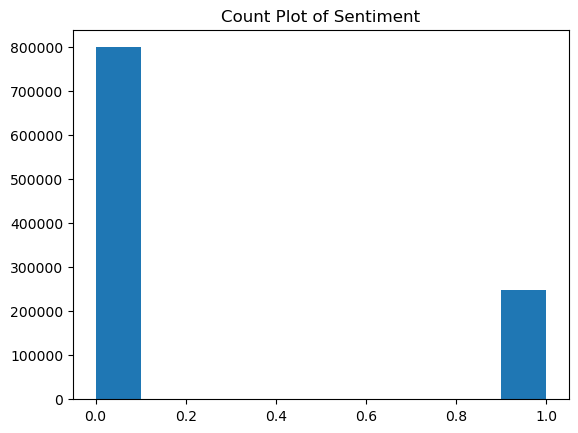

In [8]:
plt.hist(data["Sentiment"])
plt.title("Count Plot of Sentiment")
plt.show()

In [9]:
data.isna().sum()

Sentiment    0
text         0
dtype: int64

**The data is unbalanced therefore we will downsample the data to have same count for each sentiment**

### Downsampling the Dataset

In [10]:
from sklearn.utils import resample

In [11]:
# Majority class 0
data_majority = data[data["Sentiment"]==0]
# Minority class 1
data_minority=data[data["Sentiment"]==1]
        

In [12]:
data_minority.shape

(248576, 2)

In [13]:
#downsampling majority class
data_majority_downsampled = resample(data_majority,replace=False,n_samples=len(data_minority),random_state=1234)

In [14]:
data = data_majority_downsampled.append(data_minority)
data.head()

,Sentiment,text
74567,0,Wow slept for almost 12hours. Sleepy me!! Uni ...
668722,0,gets bored with an idea too easily ... like tw...
286706,0,To my girls - sorry i've been a homebody latel...
632911,0,BK once again for the weekend...If it wasnt fo...
356735,0,@DonnieWahlberg Now why didn't you do that las...


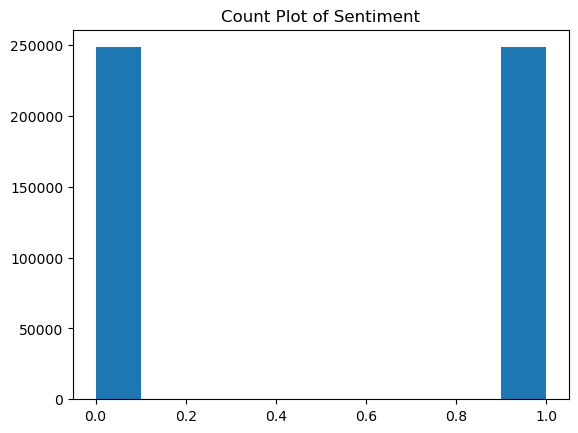

In [15]:
# Visualizing after downsampling 
plt.hist(data["Sentiment"])
plt.title("Count Plot of Sentiment")
plt.show()

## 3. Data Preprocessing

* 1. Removing stop words.
* 2. Reoving punctuations.
* 3. Lemmatizing
* 4. Removing tags.
* 5. Removing special characters.
* 6. Lowercase Conversion.**

**1. Remove stopwords and punctuation marks.**

In [16]:
to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()

corpus = data['text'].tolist()
print(len(corpus))
print(corpus[0])

497152
Wow slept for almost 12hours. Sleepy me!! Uni now, boo! I wanna stay home, drink tea and watch house... 


In [17]:
# import nltk
# nltk.download('wordnet')

In [18]:
%%time
final_corpus = []
final_corpus_joined = []
for i in data.index:
    text = re.sub('[^a-zA-Z]',',',data["text"][i])
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;","&lt;&gt;",text)
    #Remove special character and digits
    text = re.sub("(\\d|\\W)"," ",text)
    # Convert to list from string
    text = text.split()
    
    #Lemmatisation
    #lem = WordNetLemmatizer()
    #text = [lem.lemmatize(word) for word in text
    #            if not word in to_be_removed]      # This causing wordnet library error.
    text = [word for word in text
           if not word in to_be_removed]
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

CPU times: total: 21.1 s
Wall time: 25.3 s


**Storing the cleaned data seperately.**

In [19]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["Sentiment"] = data["Sentiment"].values
data_cleaned

,text,Sentiment
0,wow slept almost hours sleepy uni boo wanna st...,0
1,gets bored idea easily like twitter,0
2,girls sorry homebody lately dont feel well doe...,0
3,bk weekend wasnt puppy stay ass,0
4,donniewahlberg last night atlanta,0
...,...,...
497147,grandma making dinenr mum,1
497148,mid morning snack time bowl cheese noodles yum,1
497149,shadela say like terminiator movies comes like...,1
497150,destinyhope im great thaanks wbuu,1


In [20]:
data_cleaned["Sentiment"].value_counts()

0    248576
1    248576
Name: Sentiment, dtype: int64

## EDA

In [21]:
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['Sentiment'] = data["Sentiment"].values
data_eda.head()

,text,Sentiment
0,"[wow, slept, almost, hours, sleepy, uni, boo, ...",0
1,"[gets, bored, idea, easily, like, twitter]",0
2,"[girls, sorry, homebody, lately, dont, feel, w...",0
3,"[bk, weekend, wasnt, puppy, stay, ass]",0
4,"[donniewahlberg, last, night, atlanta]",0


In [22]:
# Storing positive data seperately
positive = data_eda[data_eda["Sentiment"]==1]
positive_list = positive["text"].tolist()

# Storing Negative Data
negative = data_eda[data_eda["Sentiment"]==0]
negative_list = negative["text"].tolist()

In [23]:
positive_all = " ".join([word for sent in positive_list for word in sent])

negative_all = " ".join([word for sent in negative_list for word in sent])

**Word Cloud Positive Data**

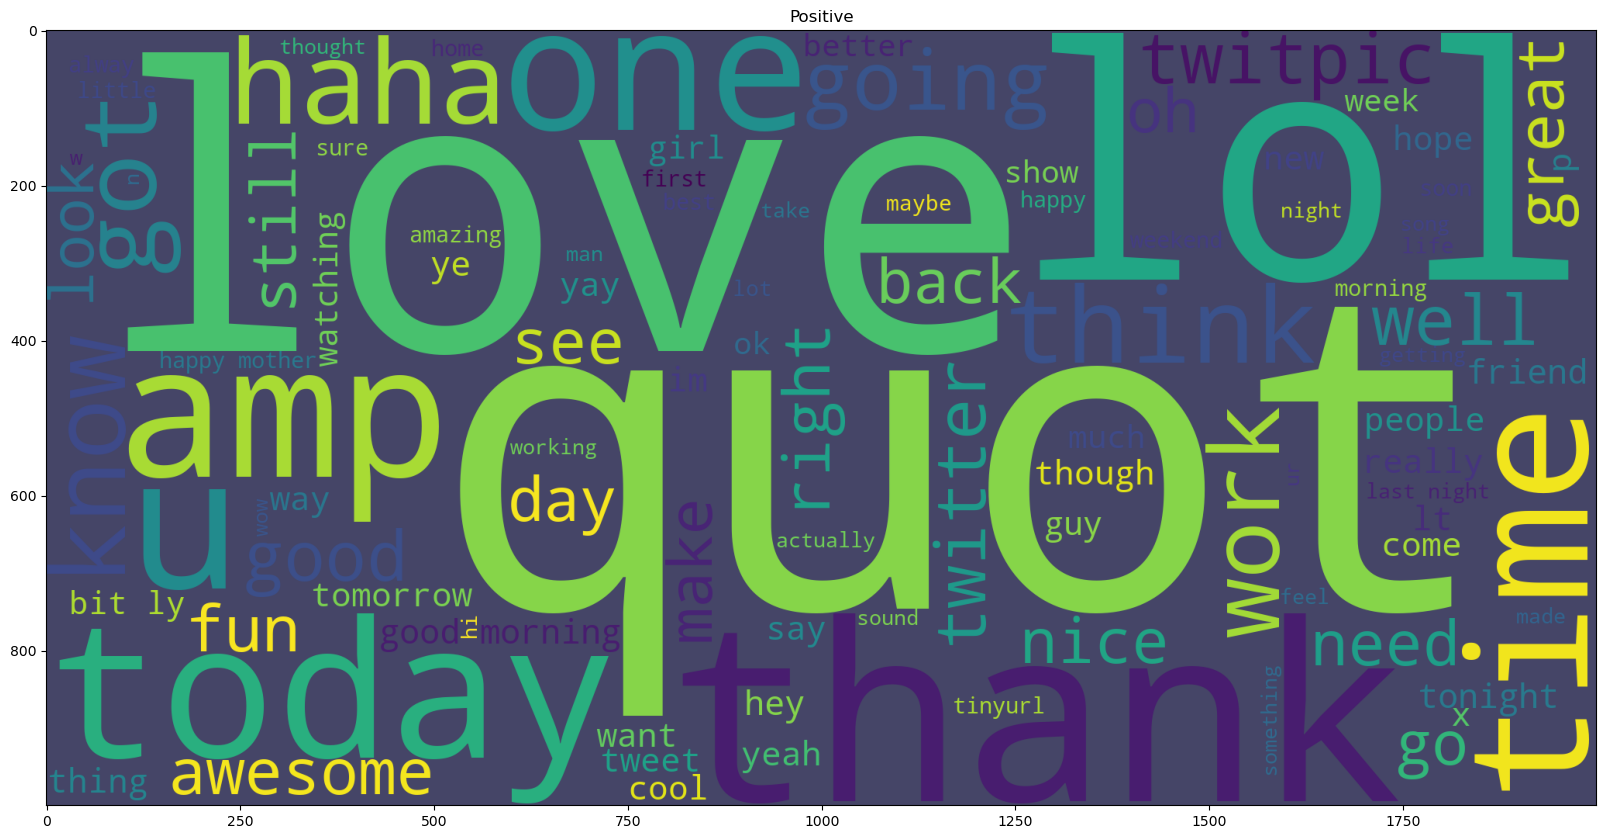

In [24]:
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                     height=1000,
                     background_color = "#454567FF",
                     max_words=100).generate(positive_all)
plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

**Word Cloud Negative Data**

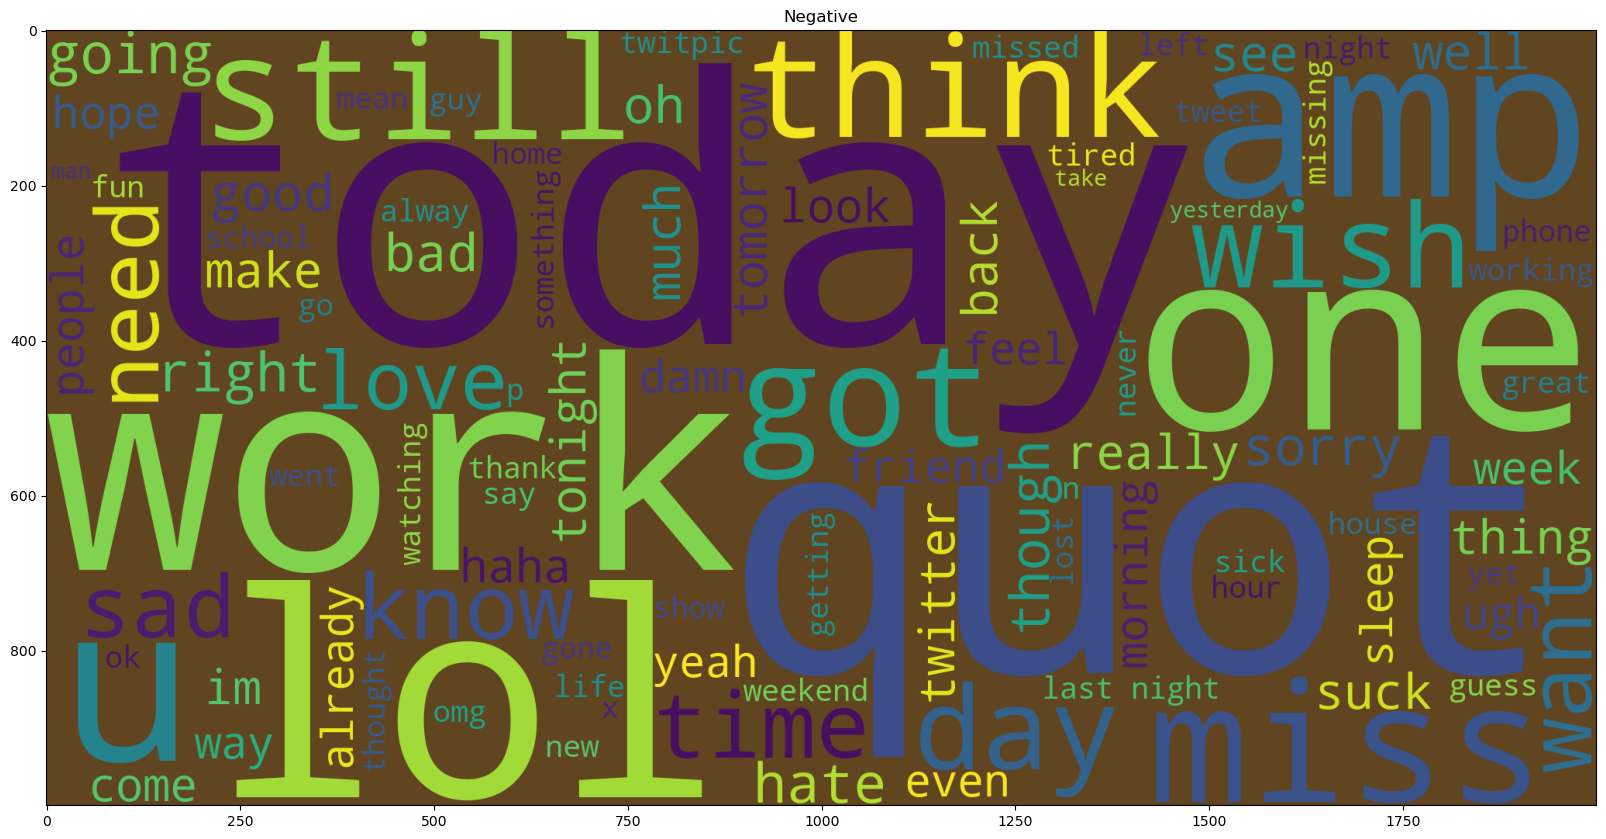

In [25]:
wordcloud
wordcloud = WordCloud(width=2000,
                     height=1000,
                     background_color = "#604520FF",
                     max_words=100).generate(negative_all)
plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Negative")
plt.show()

**Take Aways:**

* Positive Data has words like Thank, love, LoL, haha etc.
* Negative Data has words like work, quot, sad, going need.
* some of words are still common in both such as LoL,quot

**One Word Count**

In [26]:
def get_count(data):
    dic = {}
    for i in data:
        for j in i:
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1
    return dic

In [27]:
get_count(positive_list)

{'love': 14118,
 'health': 139,
 'uandpets': 6,
 'u': 9855,
 'guys': 2544,
 'r': 1789,
 'best': 3428,
 'im': 6434,
 'meeting': 602,
 'one': 8370,
 'besties': 40,
 'tonight': 3610,
 'cant': 1515,
 'wait': 4021,
 'girl': 1970,
 'talk': 1239,
 'darealsunisakim': 3,
 'thanks': 11349,
 'twitter': 6929,
 'add': 746,
 'sunisa': 1,
 'got': 8267,
 'meet': 1088,
 'hin': 4,
 'show': 2501,
 'dc': 143,
 'area': 176,
 'sweetheart': 101,
 'sick': 486,
 'really': 5887,
 'cheap': 146,
 'hurts': 152,
 'much': 5265,
 'eat': 1078,
 'real': 1217,
 'food': 1124,
 'plus': 390,
 'friends': 2358,
 'make': 3994,
 'soup': 174,
 'lovesbrooklyn': 2,
 'effect': 95,
 'everyone': 3105,
 'productoffear': 1,
 'tell': 1833,
 'burst': 19,
 'laughing': 254,
 'loud': 172,
 'making': 1352,
 'come': 3550,
 'sulk': 5,
 'keith': 40,
 'hill': 135,
 'thans': 1,
 'response': 115,
 'ihad': 3,
 'already': 1667,
 'find': 1590,
 'answer': 349,
 'keepinupwkris': 14,
 'jealous': 354,
 'hope': 6376,
 'great': 8328,
 'time': 9585,
 'vega

In [28]:
count_corpus = get_count(positive_list)

In [29]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),
                            "count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by="count",ascending=False)
count_corpus.head(15)

,word,count
497,good,20247
84,day,17174
182,http,14786
197,quot,14567
0,love,14118
65,like,11742
17,thanks,11349
184,com,11017
104,get,10902
124,lol,10741


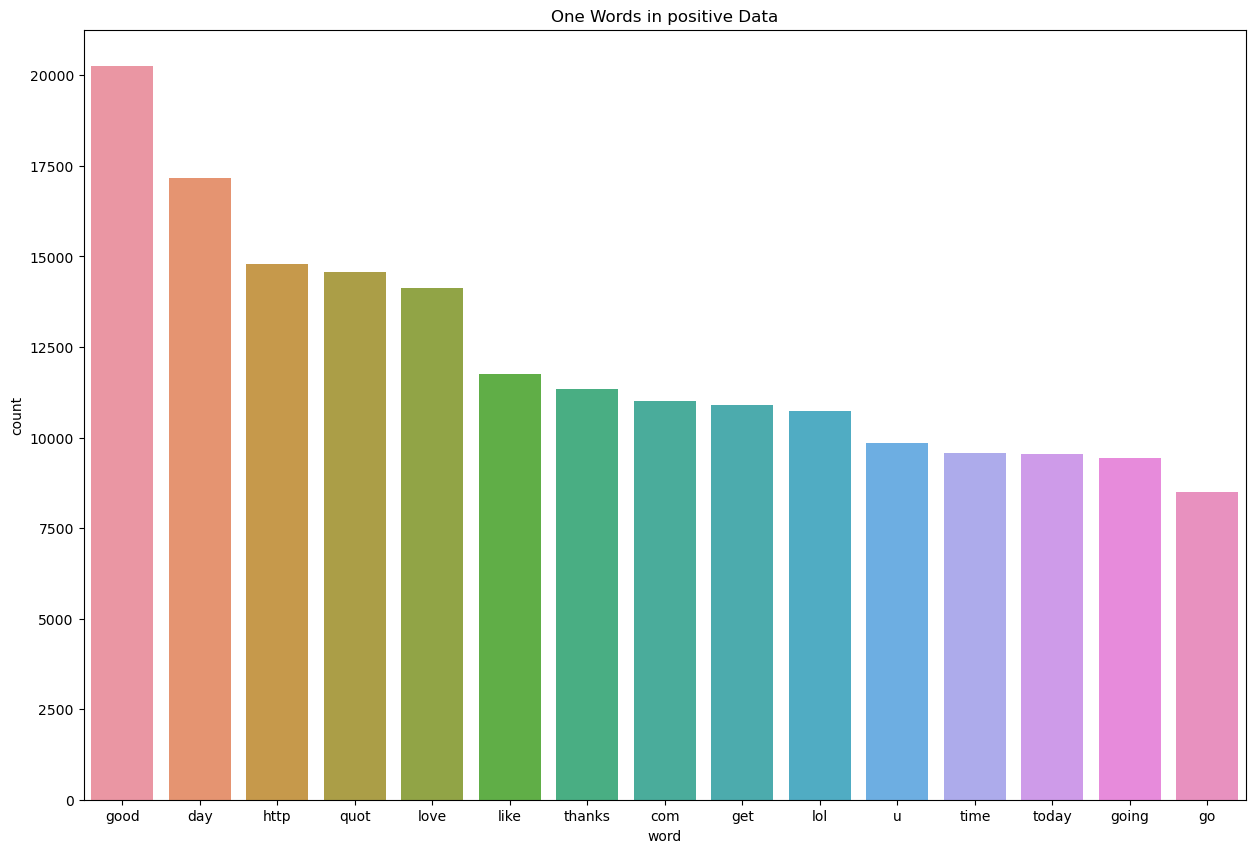

In [30]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.barplot(x=count_corpus["word"][:15],
               y=count_corpus["count"][:15])
plt.title("One Words in positive Data")
plt.show()

In [31]:
# For Negative word
count_corpus = get_count(negative_list)

In [32]:
count_corpus = pd.DataFrame({"word":count_corpus.keys(),
                             "count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)
count_corpus.head(15)

,word,count
167,get,14299
58,go,14158
142,work,14142
121,day,12965
18,like,12754
216,today,11890
67,going,10425
131,got,10286
141,back,10160
101,really,9765


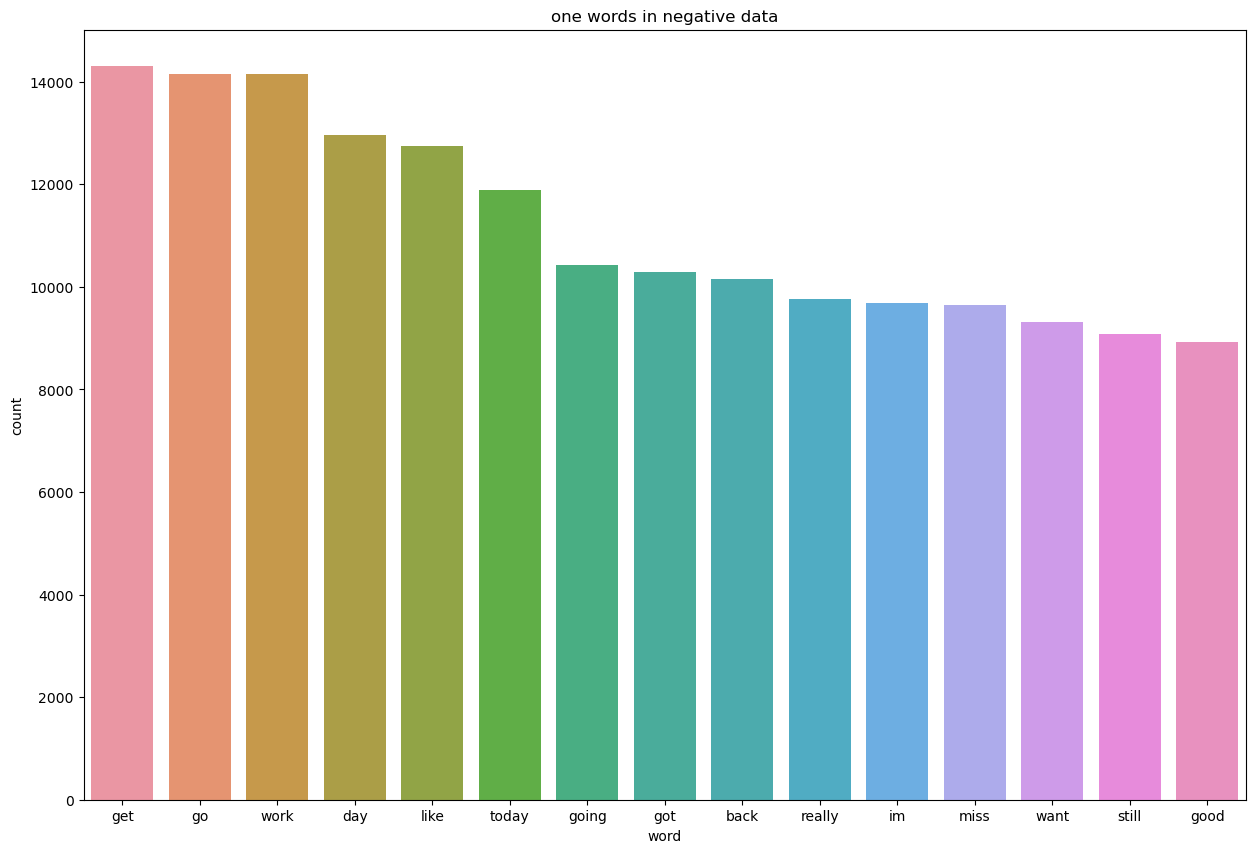

In [33]:
plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:15], 
            y = count_corpus["count"][:15])
plt.title('one words in negative data')
plt.show()

**Take Aways:**
* Positive data has words like good, day,http, great
* Negative data has words like work, miss, sad etc.

    

## Classification

### Naive Bayes for Sentiment Analysis

In [34]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token,True] for token in tweet_tokens)
        
positive_token_for_model = get_tweets_for_model(positive_list)
negative_token_for_model = get_tweets_for_model(negative_list)

In [35]:
import random
positive_dataset = [(review_dict,"Positive")
                   for review_dict in positive_token_for_model]
negative_dataset = [(review_dict,"Negative")
                   for review_dict in positive_token_for_model]
dataset = positive_dataset + negative_dataset
random.shuffle(dataset)
dataset

[({'carinak': True, 'nw': True, 'hungry': True}, 'Positive'),
 ({'mikey': True,
   'haha': True,
   'realize': True,
   'somethin': True,
   'babe': True,
   'pic': True,
   'us': True,
   'bed': True,
   'mine': True,
   'n': True},
  'Positive'),
 ({'nice': True, 'day': True}, 'Positive'),
 ({'today': True, 'great': True, 'day': True}, 'Positive'),
 ({'found': True,
   'something': True,
   'interesting': True,
   'yesterday': True,
   'purple': True,
   'corn': True,
   'really': True,
   'grows': True,
   'peru': True,
   'made': True,
   'juice': True},
  'Positive'),
 ({'norarachel': True,
   'oooh': True,
   'hope': True,
   'everything': True,
   'goes': True,
   'tickety': True,
   'boo': True,
   'course': True,
   'us': True,
   'think': True,
   'spelt': True,
   'labour': True},
  'Positive'),
 ({'going': True,
   'fleemarket': True,
   'wife': True,
   'kids': True,
   'sundays': True,
   'loooong': True,
   'nothing': True},
  'Positive'),
 ({'getting': True,
   'ready':

In [36]:
# Training Dataset Length 
# 80 percent data
round(len(dataset)*0.8)

198861

In [37]:
# Test Dataset Length
# 20 percent data
round(len(dataset) - len(dataset)*0.8)

49715

In [38]:
train_data = dataset[:198861]
test_data = dataset[198861:]

In [39]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Training Accuracy is:",round(classify.accuracy(classifier,train_data),2)*100)
print("Testing Accuracy is:",round(classify.accuracy(classifier,test_data),2)*100)

print(classifier.show_most_informative_features(10))

Training Accuracy is: 100.0
Testing Accuracy is: 100.0
Most Informative Features
None


### TFIDF for Sentiment Analysis

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['Sentiment']

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify = y)

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score ,confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

In [43]:
def metrics(model,y_train,y_train_pred,y_test,y_test_pred):
    train_ac = round(accuracy_score(y_train,y_train_pred),2)*100
    print("Training Accuracy: ",train_ac)
    ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="all")
    print(classification_report(y_train,y_train_pred))
    plt.show()
    
    test_ac = round(accuracy_score(y_test,y_test_pred),2)*100
    print("Test Accuracy: ",test_ac)
    ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred,normalize="all")
    print(classification_report(y_test,y_test_pred))
    plt.show()


### Mutlinomial NB

Training Accuracy:  85.0
              precision    recall  f1-score   support

           0       0.83      0.88      0.86    166545
           1       0.87      0.82      0.85    166546

    accuracy                           0.85    333091
   macro avg       0.85      0.85      0.85    333091
weighted avg       0.85      0.85      0.85    333091



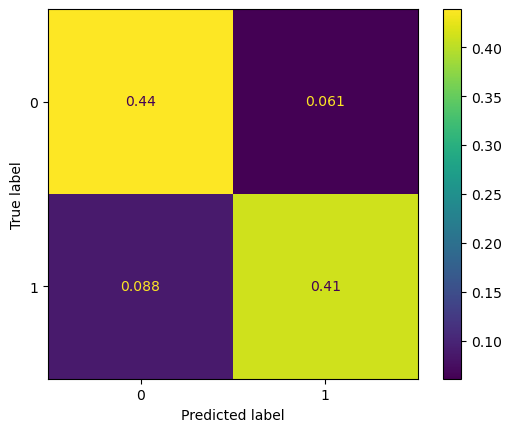

Test Accuracy:  76.0
              precision    recall  f1-score   support

           0       0.75      0.80      0.77     82031
           1       0.78      0.73      0.75     82030

    accuracy                           0.76    164061
   macro avg       0.76      0.76      0.76    164061
weighted avg       0.76      0.76      0.76    164061



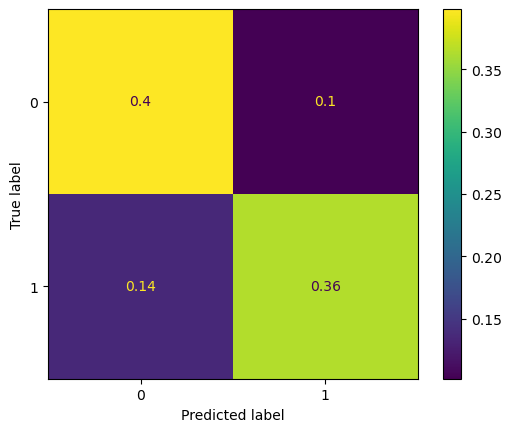

In [44]:
NB = MultinomialNB()
NB.fit(X_train,y_train)
y_train_pred = NB.predict(X_train)
y_test_pred = NB.predict(X_test)
metrics("Mutlinomial NB",y_train,y_train_pred,y_test,y_test_pred)

### Linear SVC

Training Accuracy:  90.0
              precision    recall  f1-score   support

           0       0.91      0.90      0.90    166545
           1       0.90      0.91      0.90    166546

    accuracy                           0.90    333091
   macro avg       0.90      0.90      0.90    333091
weighted avg       0.90      0.90      0.90    333091



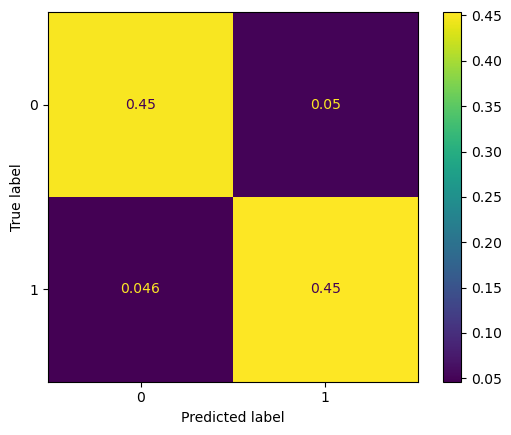

Test Accuracy:  77.0
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     82031
           1       0.76      0.78      0.77     82030

    accuracy                           0.77    164061
   macro avg       0.77      0.77      0.77    164061
weighted avg       0.77      0.77      0.77    164061



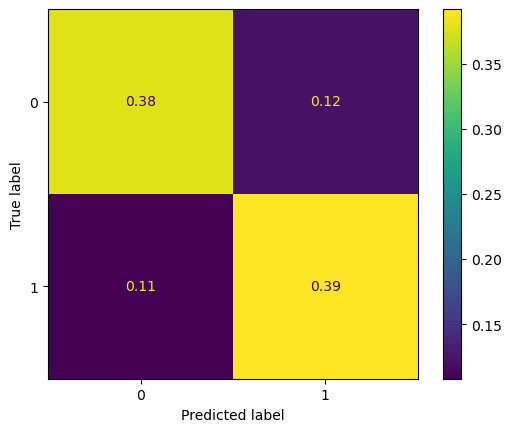

In [45]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics("Linear SVC",y_train,y_train_pred,y_test,y_test_pred)

### Logistic Regression

Training Accuracy:  83.0
              precision    recall  f1-score   support

           0       0.84      0.81      0.82    166545
           1       0.82      0.84      0.83    166546

    accuracy                           0.83    333091
   macro avg       0.83      0.83      0.83    333091
weighted avg       0.83      0.83      0.83    333091



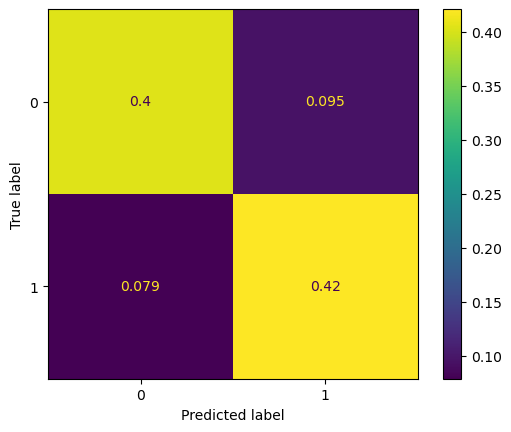

Test Accuracy:  78.0
              precision    recall  f1-score   support

           0       0.79      0.76      0.77     82031
           1       0.77      0.80      0.78     82030

    accuracy                           0.78    164061
   macro avg       0.78      0.78      0.78    164061
weighted avg       0.78      0.78      0.78    164061



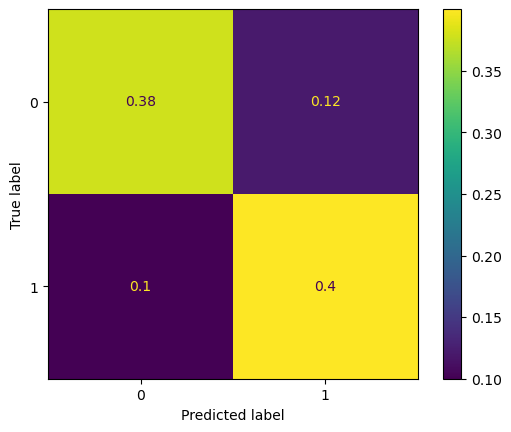

In [46]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics("Logistic Regression",y_train,y_train_pred,y_test,y_test_pred)

## Conclusion

From above we can see that Logestic regression model performs best with least overfitting as compared to other model has better pperformace in testing dataset as well. 